# Decision Trees: Regression

In [1]:
# Importing necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as kh
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

## Loading, Defining and Understanding the Data

In [3]:
path = kh.dataset_download("kukuroo3/flight-price-predict-competition-format")
X_test, X_train, y_test, y_train = pd.read_csv(f'{path}/X_test.csv'), pd.read_csv(f'{path}/X_train.csv'), pd.read_csv(f'{path}/y_test.csv'), pd.read_csv(f'{path}/y_train.csv')

In [4]:
# Connecting train and test data
X_train['is_train'] = 1
X_test['is_train'] = 0

y_train['is_train'] = 1
y_test['is_train'] = 0

X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [5]:
X.head()

,filghtId,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left,is_train
0,252589,Vistara,UK-808,Bangalore,Early_Morning,one,Night,Mumbai,13.25,46,1
1,223754,Vistara,UK-927,Delhi,Morning,one,Evening,Chennai,10.42,31,1
2,243398,Vistara,UK-988,Mumbai,Night,one,Morning,Chennai,13.00,28,1
3,208360,Vistara,UK-815,Delhi,Morning,one,Night,Mumbai,12.67,17,1
4,247226,Vistara,UK-854,Bangalore,Evening,one,Morning,Delhi,13.67,32,1


In [6]:
y.head()

,filghtId,price,is_train
0,252589,69244,1
1,223754,52392,1
2,243398,61933,1
3,208360,53164,1
4,247226,42521,1


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filghtId          9045 non-null   int64  
 1   airline           9045 non-null   object 
 2   flight            9045 non-null   object 
 3   source_city       9045 non-null   object 
 4   departure_time    9045 non-null   object 
 5   stops             9045 non-null   object 
 6   arrival_time      9045 non-null   object 
 7   destination_city  9045 non-null   object 
 8   duration          9045 non-null   float64
 9   days_left         9045 non-null   int64  
 10  is_train          9045 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 777.4+ KB


In [8]:
X.describe()

,filghtId,duration,days_left,is_train
count,9045.000000,9045.000000,9045.000000,9045.000000
mean,252355.523162,13.673428,25.814925,0.629961
std,29467.328614,6.839508,13.514093,0.482841
min,7837.000000,1.250000,1.000000,0.000000
25%,229370.000000,8.750000,14.000000,0.000000
50%,252789.000000,13.000000,26.000000,1.000000
75%,276398.000000,17.670000,37.000000,1.000000
max,300152.000000,45.830000,49.000000,1.000000


In [9]:
X.head()

,filghtId,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left,is_train
0,252589,Vistara,UK-808,Bangalore,Early_Morning,one,Night,Mumbai,13.25,46,1
1,223754,Vistara,UK-927,Delhi,Morning,one,Evening,Chennai,10.42,31,1
2,243398,Vistara,UK-988,Mumbai,Night,one,Morning,Chennai,13.00,28,1
3,208360,Vistara,UK-815,Delhi,Morning,one,Night,Mumbai,12.67,17,1
4,247226,Vistara,UK-854,Bangalore,Evening,one,Morning,Delhi,13.67,32,1


In [10]:
# Drop unnecessary columns
X.drop(['filghtId', 'flight'], axis=1, inplace=True)
y.drop(['filghtId'], axis=1, inplace=True)

In [11]:
X['airline'].value_counts()

airline
Vistara      5831
Air_India    3195
Indigo          6
GO_FIRST        5
SpiceJet        4
AirAsia         4
Name: count, dtype: int64

In [12]:
X['source_city'].value_counts()

source_city
Mumbai       1904
Delhi        1804
Bangalore    1665
Kolkata      1248
Hyderabad    1226
Chennai      1198
Name: count, dtype: int64

In [13]:
X['departure_time'].value_counts()

departure_time
Morning          2241
Evening          2022
Early_Morning    1943
Night            1656
Afternoon        1179
Late_Night          4
Name: count, dtype: int64

In [14]:
X['stops'].unique()

array(['one', 'zero', 'two_or_more'], dtype=object)

## Visualizing the Data

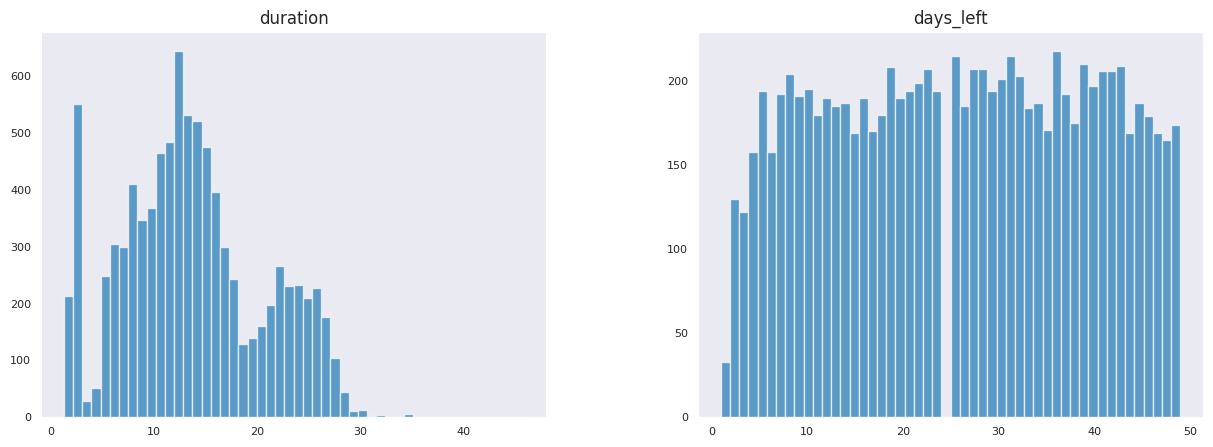

In [15]:
# Histogram
X[['duration', 'days_left']].hist(figsize=(15, 5), bins=50, xlabelsize=8, ylabelsize=8, grid=False, alpha=0.7)
plt.show()

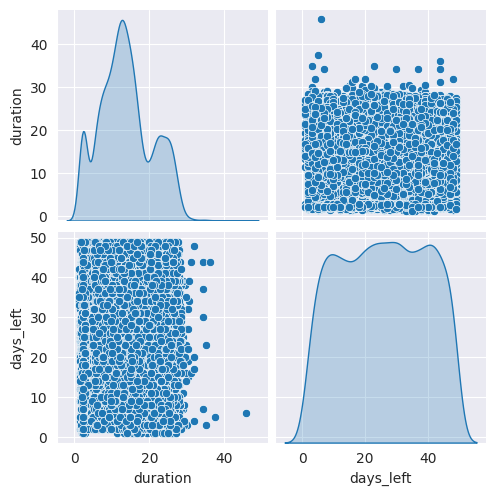

In [16]:
# Pairplot
sns.pairplot(X[['duration', 'days_left']], diag_kind='kde')
plt.show()

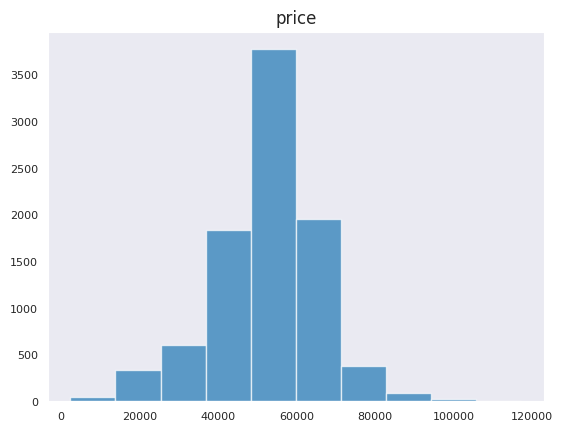

In [17]:
# Histogram of the target variable
y[['price']].hist(xlabelsize=8, ylabelsize=8, grid=False, alpha=0.7)
plt.show()

## Preprocessing the Data

In [18]:
X.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left,is_train
0,Vistara,Bangalore,Early_Morning,one,Night,Mumbai,13.25,46,1
1,Vistara,Delhi,Morning,one,Evening,Chennai,10.42,31,1
2,Vistara,Mumbai,Night,one,Morning,Chennai,13.00,28,1
3,Vistara,Delhi,Morning,one,Night,Mumbai,12.67,17,1
4,Vistara,Bangalore,Evening,one,Morning,Delhi,13.67,32,1


In [19]:
cat_cols = ['airline', 'source_city', 'destination_city', 'departure_time', 'stops', 'arrival_time']

In [20]:
X = pd.get_dummies(X, columns = cat_cols, drop_first=True)
X.head()

,duration,days_left,is_train,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,stops_two_or_more,stops_zero,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,13.25,46,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,10.42,31,1,False,False,False,False,True,False,True,...,False,True,False,False,False,False,True,False,False,False
2,13.00,28,1,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,12.67,17,1,False,False,False,False,True,False,True,...,False,True,False,False,False,False,False,False,False,True
4,13.67,32,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [21]:
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['bool']).columns})

In [22]:
X.head()

,duration,days_left,is_train,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,stops_two_or_more,stops_zero,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,13.25,46,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10.42,31,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,13.00,28,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,12.67,17,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
4,13.67,32,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
X.shape

(9045, 30)

In [24]:
y.describe()

,price,is_train
count,9045.000000,9045.000000
mean,52198.478165,0.629961
std,13179.175493,0.482841
min,2339.000000,0.000000
25%,44610.000000,0.000000
50%,53164.000000,1.000000
75%,60365.000000,1.000000
max,117307.000000,1.000000


In [25]:
# scaler
scaler = StandardScaler()

y['price'] = scaler.fit_transform(y[['price']])
X[['duration', 'days_left']] = scaler.fit_transform(X[['duration', 'days_left']])

In [26]:
X.describe()

,duration,days_left,is_train,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,stops_two_or_more,stops_zero,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
count,9.045000e+03,9.045000e+03,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,...,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000
mean,-1.610406e-16,-7.973476e-17,0.629961,0.353234,0.000553,0.000663,0.000442,0.644666,0.132449,0.199447,...,0.000442,0.247761,0.183085,0.010724,0.085240,0.040907,0.273853,0.021891,0.230735,0.311001
std,1.000055e+00,1.000055e+00,0.482841,0.478001,0.023506,0.025748,0.021026,0.478641,0.338997,0.399607,...,0.021026,0.431736,0.386757,0.103006,0.279255,0.198085,0.445959,0.146334,0.421327,0.462929
min,-1.816522e+00,-1.836327e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.198911e-01,-8.743153e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-9.846698e-02,1.369569e-02,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.843685e-01,8.277058e-01,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,4.701852e+00,1.715717e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
y.describe()

,price,is_train
count,9.045000e+03,9045.000000
mean,9.426769e-18,0.629961
std,1.000055e+00,0.482841
min,-3.783411e+00,0.000000
25%,-5.758249e-01,0.000000
50%,7.326522e-02,1.000000
75%,6.196877e-01,1.000000
max,4.940531e+00,1.000000


## Training, Predicting and Evaluating the Model

In [28]:
# Split the data into train and test sets
X_train = X[X['is_train'] == 1].drop(columns=['is_train'])
X_test = X[X['is_train'] == 0].drop(columns=['is_train'])

y_train = y[y['is_train'] == 1].drop(columns=['is_train'])
y_test = y[y['is_train'] == 0].drop(columns=['is_train'])

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5698, 29), (3347, 29), (5698, 1), (3347, 1))

In [30]:
# Initialize the model
dt_reg = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    criterion='squared_error',
    splitter='best',
    max_features=None,
)

In [31]:
# Fit the model
dt_reg.fit(X_train, y_train)

# Predict the target variable
y_pred = dt_reg.predict(X_test)

In [32]:
# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

RMSE: 0.6192125296115304
MSE: 0.38342415682791037
R2: 0.6239767238637239


## Hyperparameter Tuning: Randomized Search

In [40]:
# Define the parameter grid
param_grid = {
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random']
}

In [41]:
# Initialize the model
dt_reg_best = DecisionTreeRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_reg_best,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    error_score='raise'
)

In [42]:
# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best R2 Score: {best_score}')

Best Parameters: {'splitter': 'best', 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(8), 'max_features': None, 'max_depth': np.int64(19), 'criterion': 'squared_error'}
Best R2 Score: 0.627671147143723


In [43]:
# Initialize the model with the best parameters
dt_reg_best = DecisionTreeRegressor(**best_params)
dt_reg_best.fit(X_train, y_train)

# Predict the target variable
y_pred_best = dt_reg_best.predict(X_test)

In [44]:
# Evaluate the model
rmse_best = root_mean_squared_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best RMSE: {rmse_best}")
print(f"Best MSE: {mse_best}")
print(f"Best R2: {r2_best}")

Best RMSE: 0.5939371439379091
Best MSE: 0.35276133094912054
Best R2: 0.6540476936688779
